In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.5 MB/s eta 0:00:00


In [ ]:
#importing libraries.
import os
from importlib.metadata import version
import torch
import torch.nn as nn
print("torch version:", version("torch"))
import tiktoken
print("tiktoken version:", version("tiktoken"))

torch version: 2.6.0+cu124
tiktoken version: 0.9.0


In [ ]:
#this dictionary defines the architecture and training parameters for a 124 million parameter GPT model.
#total number of trainable parameters are - 124 million.

GPT_CONFIG_124M = {
    #the number of unique tokens that the model can recognize and generate.
    "vocab_size": 50257,

    #the maximum number of tokens the model can process in a single forward pass.
    "context_length": 1024,

    #the size of the vector space used to represent each token.
    "emb_dim": 768,

    #the number of attention heads in each transformer layer.
    "n_heads": 12,

    #the number of transformer layers stacked on top of each other.
    "n_layers": 12,

    #the probability of randomly disabling neurons during training.
    "drop_rate": 0.1,

    #indicates whether bias terms are included in the query, key, and value projections of the attention mechanism.
    "qkv_bias": False
}

In [ ]:
import urllib.request

file_path_1 = "text_data_1.txt"
url = "https://www.gutenberg.org/cache/epub/1342/pg1342.txt"

if not os.path.exists(file_path_1):
    with urllib.request.urlopen(url) as response:
        text_data_1 = response.read().decode('utf-8')
    with open(file_path_1, "w", encoding="utf-8") as file:
        file.write(text_data_1)
else:
    with open(file_path_1, "r", encoding="utf-8") as file:
        text_data_1 = file.read()


In [ ]:
file_path_2 = "text_data_2.txt"
url = "https://www.gutenberg.org/cache/epub/1400/pg1400.txt"

if not os.path.exists(file_path_2):
    with urllib.request.urlopen(url) as response:
        text_data_2 = response.read().decode('utf-8')
    with open(file_path_2, "w", encoding="utf-8") as file:
        file.write(text_data_2)
else:
    with open(file_path_2, "r", encoding="utf-8") as file:
        text_data_2 = file.read()

In [ ]:
dataset = text_data_1 + text_data_2
assert(len(dataset) == len(text_data_1) + len(text_data_2))

In [ ]:
with open("final_dataset.txt", "w", encoding = "utf-8") as file_1:
    file_1.write(dataset)

In [ ]:
with open("final_dataset.txt", "r", encoding = "utf-8") as raw_text:
  raw_text = raw_text.read()

In [ ]:
from importlib.metadata import version
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.6.0+cu124
tiktoken version: 0.9.0


In [ ]:
total_characters = len(raw_text)
total_tokens = len(tokenizer.encode(raw_text))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 1762018
Tokens: 480074


In [ ]:
train_ratio = 0.90
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert(d_out % num_heads == 0)
        self.d_out = d_out
        self.num_heads = num_heads

        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(
            b, num_tokens, self.d_out
        )
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_resid(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut  # Add the original input back

        return x

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [ ]:
def generate_text(model, idx, max_new_tokens, context_size, device):
    idx = idx.to(device)
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [ ]:
#helper function that takes a text string and tokenizer, then returns a properly formatted tensor.
def text_to_token_ids(text, tokenizer):

    #encodes the text into token IDs, allows the special end-of-text token
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})

    #converts to a tensor and adds the batch dimension
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)

    #returns the ready-to-use tensor
    return encoded_tensor

#function that converts generated token IDs back to human-readable text.
def token_ids_to_text(token_ids, tokenizer):

    #removes the batch dimension with 'squeeze(0)'
    flat = token_ids.squeeze(0)

    #decodes the token IDs to text and converts the tensor to a python list with tolist()
    return tokenizer.decode(flat.tolist())


In [ ]:
#we create a class which inherits from pytorch's 'Dataset' class, which is part of the data loading infrastructure in pytorch.
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):

     #txt: the raw text to train on.
     #tokenizer: the tokenizer to convert text to token IDs.
     #max_length: the maximum sequence length for each training example.
     #stride: how much to shift the window when creating the next training example.
     def __init__(self, txt, tokenizer, max_length, stride):

         #these lists will store the input sequences and their corresponding target sequences.
         self.input_ids = []
         self.target_ids = []

         #encodes the entire text into token IDs, allowing the special end-of-text token to be included.
         token_ids = tokenizer.encode(txt, allowed_special = {"<|endoftext|>"})
         assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

         #this loop iterates through the token IDs, jumping stride positions each time. this creates overlapping chunks if stride < max_length, which is a common approach to efficiently use all the data.
         for i in range(0, len(token_ids) - max_length, stride):

             #input_chunk is a sequence of max_length tokens starting at position i.
             input_chunk = token_ids[i:i + max_length]

             #target_chunk is a sequence of the same length but shifted one position forward.
             target_chunk = token_ids[i + 1: i + max_length + 1]

             #each chunk is converted to a PyTorch tensor and stored in the appropriate list.
             self.input_ids.append(torch.tensor(input_chunk))
             self.target_ids.append(torch.tensor(target_chunk))

     #returns the number of examples in the dataset.
     def __len__(self):
         return len(self.input_ids)

     #returns a specific example from the dataset given its index.
     def __getitem__(self, idx):
         return self.input_ids[idx], self.target_ids[idx]

In [ ]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2")

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
 )

    return dataloader

In [ ]:
train_loader = create_dataloader_v1(
     train_data,
     batch_size=2,
     max_length=GPT_CONFIG_124M["context_length"],
     stride=GPT_CONFIG_124M["context_length"],
     drop_last=True,
     shuffle=True,
     num_workers=0
)


val_loader = create_dataloader_v1(
     val_data,
     batch_size=2,
     max_length=GPT_CONFIG_124M["context_length"],
     stride=GPT_CONFIG_124M["context_length"],
     drop_last=False,
     shuffle=False,
     num_workers=0
)

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
     input_batch, target_batch = input_batch.to(device), target_batch.to(device)
     logits = model(input_batch)
     loss = torch.nn.functional.cross_entropy(
         logits.flatten(0, 1), target_batch.flatten()
     )
     return loss

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
     total_loss = 0
     if len(data_loader) == 0:
         return float("nan")
     elif num_batches is None:
         num_batches = len(data_loader)
     else:
         num_batches = min(num_batches, len(data_loader))
     for i, (input_batch, target_batch) in enumerate(data_loader):
         if i < num_batches:
             loss = calc_loss_batch(
                 input_batch, target_batch, model, device
             )
             total_loss += loss.item()
         else:
             break
     return total_loss / num_batches

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.997751081557501
Validation loss: 10.990206552588422


In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size, device=device
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.00005, weight_decay=0.02
)
num_epochs = 5

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=10, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.711, Val loss 10.712
Ep 1 (Step 000010): Train loss 9.009, Val loss 9.053
Ep 1 (Step 000020): Train loss 8.447, Val loss 8.469
Ep 1 (Step 000030): Train loss 8.127, Val loss 8.020
Ep 1 (Step 000040): Train loss 6.900, Val loss 7.566
Ep 1 (Step 000050): Train loss 7.197, Val loss 7.143
Ep 1 (Step 000060): Train loss 6.355, Val loss 6.815
Ep 1 (Step 000070): Train loss 6.486, Val loss 6.569
Ep 1 (Step 000080): Train loss 6.215, Val loss 6.386
Every effort moves you, and                                                
Ep 2 (Step 000090): Train loss 6.358, Val loss 6.235
Ep 2 (Step 000100): Train loss 6.054, Val loss 6.124
Ep 2 (Step 000110): Train loss 5.553, Val loss 6.034
Ep 2 (Step 000120): Train loss 5.479, Val loss 5.963
Ep 2 (Step 000130): Train loss 5.561, Val loss 5.900
Ep 2 (Step 000140): Train loss 5.504, Val loss 5.836
Ep 2 (Step 000150): Train loss 5.391, Val loss 5.783
Ep 2 (Step 000160): Train loss 5.622, Val loss 5.740
Ep 2 (Step 000170): T

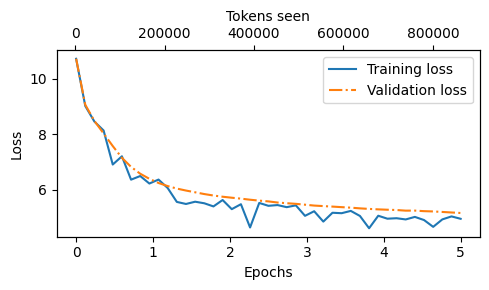

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
def user_input(context):
  generate_and_print_sample(model, tokenizer, device, context)

In [ ]:
context = input("please enter starting context: ")
user_input(context)

please enter starting context: Hello I am Prakhar 
Hello I am Prakhar                                                   


In [ ]:
torch.save(model.state_dict(), "model.pth")

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();